In [1]:
from eeg_lib.data.data_setup import TripletEEGDataset
from eeg_lib.data.data_loader.EEGDataExtractor import EEGDataExtractor
from eeg_lib.models.verification.EEGNet import EEGNetEmbeddingModel
from eeg_lib.commons.constant import DATASETS_FOLDER


from eeg_lib.utils.helpers import create_writer, split_train_test
from eeg_lib.utils.engine import train_triplet_model, extract_embeddings, verify_sample, create_user_profiles, verify_test_sample

from eeg_lib.utils.visualisations import visualize_umap, visualize_tsne, calculate_and_plot_distances

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

extractor = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants = extractor.extract_dataframe()

In [3]:
eeg_df.head()

,participant_id,epoch,label
0,46607ce4@1717,"[[-9.24481589731569e-06, -9.598635937503012e-0...",gray
1,46607ce4@1717,"[[-2.0148758591275883e-06, -1.1913500968321893...",green
2,46607ce4@1717,"[[-1.7344745961061525e-07, 1.012701607648391e-...",gray
3,46607ce4@1717,"[[4.047473978354836e-06, 2.417326642595136e-06...",blue
4,46607ce4@1717,"[[-8.859812648227801e-06, -1.0092267325555332e...",gray


In [4]:
print(eeg_df.columns)

Index(['participant_id', 'epoch', 'label'], dtype='object')


In [5]:
train_df, test_df, train_participants, test_participants = split_train_test(eeg_df=eeg_df, test_size=0.20, random_state=42)

Training set participants: ['d87e1bd3@1806' '541c91f2@1456' '8dca0725@1418' '46607ce4@1717'
 '51ec2c20@0923' 'e283301e@1606' '90441f44@1643' 'ffae50df@1712'
 '022e8467@1910' '548fd734@1628' 'bf2d2193@1638' '9e8bae0e@1828'
 'fd8a3308@1135' 'e43a9f9f@0941' 'b34b1427@0906' '011595b1@1651'
 '2882ae26@1441' 'e08138e2@1731' '8bd3032e@1746' 'f82b5699@1757'
 '54e60118@1339' '3033b74a@1626' '06f240e9@1215' '25d0bdb3@1318']
Test set participants: ['446b3735@1618' '2718372d@1400' '6d9a8b86@1613' '6e542bc2@0845'
 '39285860@1825' '36eea4bb@1519']


In [11]:
triplet_train_dataset = TripletEEGDataset(train_df)
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=8, shuffle=True)

model = EEGNetEmbeddingModel(
    num_channels=4, num_time_points=751, num_classes=0, embedding_dimension=32
)

triplet_loss_fn = nn.TripletMarginLoss(margin=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

NUM_EPOCHS = 46

# writer = create_writer("EEGNet Triplet Loss", "EEGNet", "triplet loss")

results, _ = train_triplet_model(model, triplet_train_loader, triplet_loss_fn, optimizer, NUM_EPOCHS)

/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 1, Average Loss: 0.1004
Epoch 2, Average Loss: 0.0737
Epoch 3, Average Loss: 0.0538
Epoch 4, Average Loss: 0.0511
Epoch 5, Average Loss: 0.0467
Epoch 6, Average Loss: 0.0466
Epoch 7, Average Loss: 0.0450
Epoch 8, Average Loss: 0.0403
Epoch 9, Average Loss: 0.0359
Epoch 10, Average Loss: 0.0326
Epoch 11, Average Loss: 0.0295
Epoch 12, Average Loss: 0.0280
Epoch 13, Average Loss: 0.0249
Epoch 14, Average Loss: 0.0224
Epoch 15, Average Loss: 0.0213
Epoch 16, Average Loss: 0.0209
Epoch 17, Average Loss: 0.0204
Epoch 18, Average Loss: 0.0205
Epoch 19, Average Loss: 0.0190
Epoch 20, Average Loss: 0.0201
Epoch 21, Average Loss: 0.0184
Epoch 22, Average Loss: 0.0201
Epoch 23, Average Loss: 0.0192
Epoch 24, Average Loss: 0.0174
Epoch 25, Average Loss: 0.0179
Epoch 26, Average Loss: 0.0171
Epoch 27, Average Loss: 0.0169
Epoch 28, Average Loss: 0.0165
Epoch 29, Average Loss: 0.0165
Epoch 30, Average Loss: 0.0174
Epoch 31, Average Loss: 0.0166
Epoch 32, Average Loss: 0.0171
Epoch 33, Average

In [12]:
embeddings_array, participant_ids_array = extract_embeddings(model, test_df)

In [13]:
user_profiles = create_user_profiles(embeddings_array, participant_ids_array)

In [14]:
sample_index = 0
threshold = 0.87
accepted, distance = verify_test_sample(test_df, model, user_profiles, sample_index, threshold)
print(f"Sample {sample_index} verification result: {'Accepted' if accepted else 'Rejected'}, Distance: {distance}")

Sample 0 verification result: Accepted, Distance: 0.06735267490148544


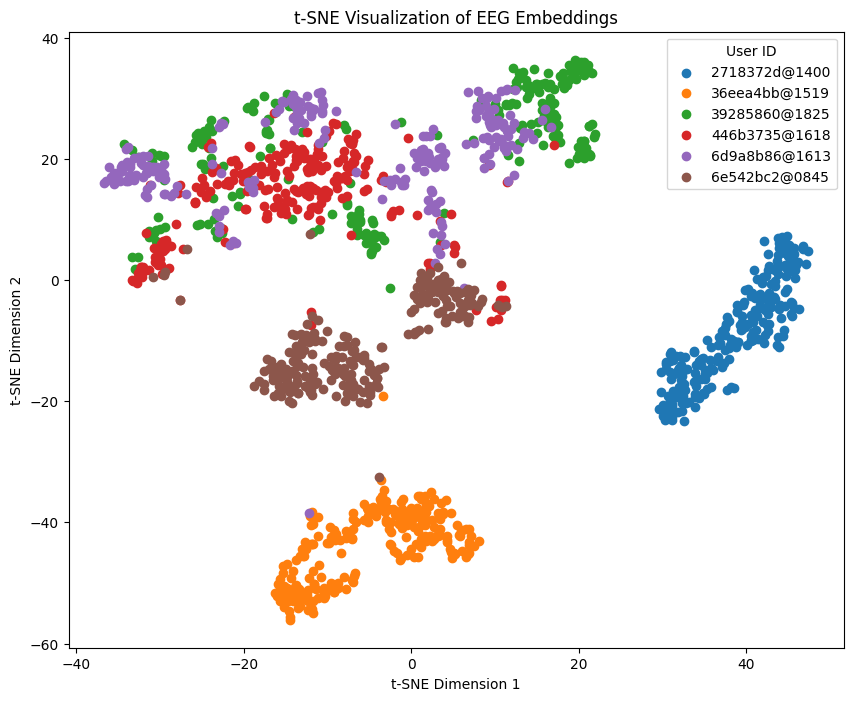

In [15]:
visualize_tsne(embeddings_array, participant_ids_array)

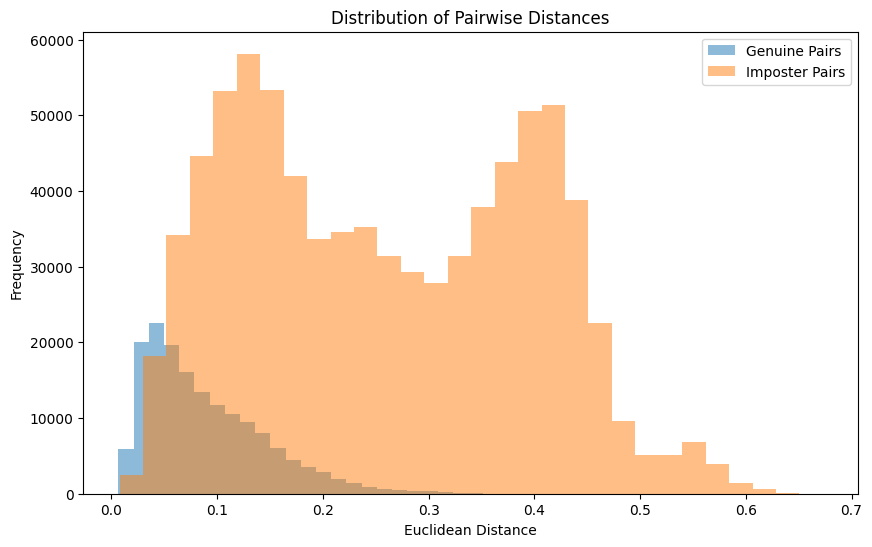

In [16]:
genuine_distances, imposter_distances = calculate_and_plot_distances(embeddings_array, participant_ids_array)

/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gsk/documents/projects/artificial-intelligence/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


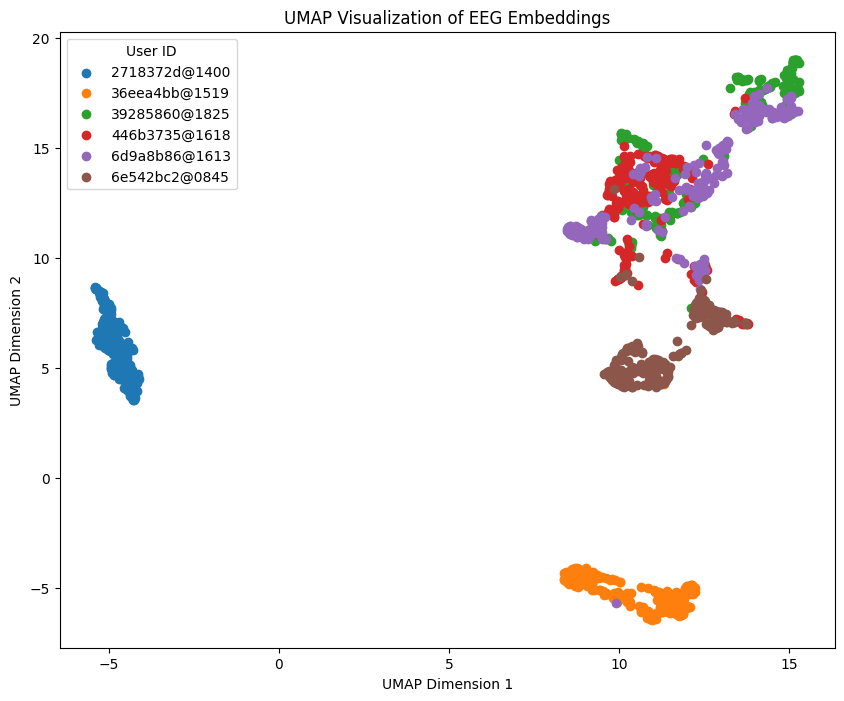

In [17]:
visualize_umap(embeddings_array, participant_ids_array)

Extracted embeddings shape: (5568, 32)
Selected threshold = 0.1529, EER = 0.1615 (FRR = 0.1578, FAR = 0.1651)


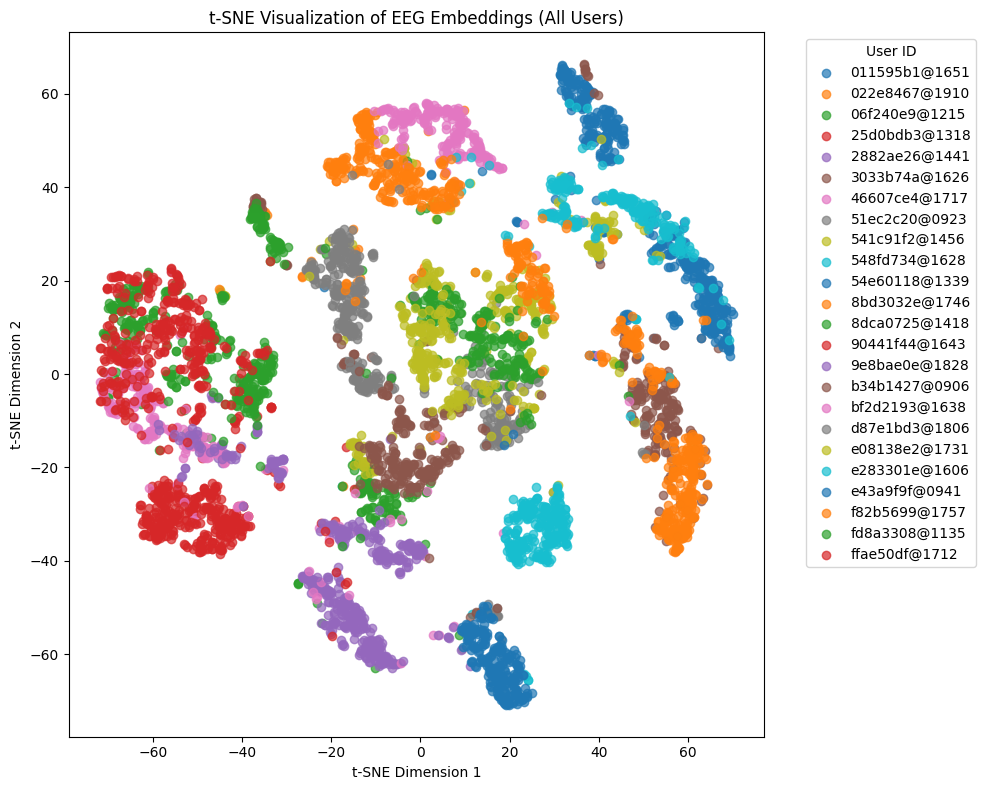

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from torch.utils.tensorboard.writer import SummaryWriter
from typing import Optional
from eeg_lib.utils.helpers import get_device


# extract_embeddings(model, test_df, device)
# compute_pairwise_distances(embeddings_array, participant_ids_array)
# find_eer_threshold(genuine_distances, imposter_distances)
# plot_2d_embeddings(embeddings_2d, participant_ids, method_name)

def extract_embeddings(model, test_df, device=get_device()):
    """
    Extracts and L2-normalizes embeddings for each sample in test_df using the given model.

    Args:
        model (nn.Module): Trained EEGNet model.
        test_df (pd.DataFrame): Test DataFrame with columns 'participant_id' and 'epoch'
            (where 'epoch' is a (4, 751) array).
        device (str): Device to use for inference.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - embeddings_array: Array of shape (N, embedding_dim) with embeddings.
            - participant_ids_array: Array of shape (N,) with corresponding participant IDs.
    """
    model.eval()
    model.to(device)
    embeddings_list = []
    participant_ids_list = []
    
    with torch.no_grad():
        for i, row in test_df.iterrows():
            # Convert epoch (4,751) to shape (1,1,4,751) for the model
            data = torch.tensor(row['epoch'], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            emb, _ = model(data)
            emb = F.normalize(emb, p=2, dim=1)
            embeddings_list.append(emb.squeeze(0).cpu().numpy())
            participant_ids_list.append(row['participant_id'])
            
    embeddings_array = np.stack(embeddings_list, axis=0)
    participant_ids_array = np.array(participant_ids_list)
    return embeddings_array, participant_ids_array

def compute_pairwise_distances(embeddings_array, participant_ids_array):
    """
    Computes pairwise Euclidean distances between embeddings and separates genuine (same user)
    and imposter (different user) distances.

    Args:
        embeddings_array (np.ndarray): Array of shape (N, D).
        participant_ids_array (np.ndarray): Array of shape (N,).

    Returns:
        Tuple[list, list]: (genuine_distances, imposter_distances)
    """
    genuine_distances = []
    imposter_distances = []
    N = len(embeddings_array)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(embeddings_array[i] - embeddings_array[j])
            if participant_ids_array[i] == participant_ids_array[j]:
                genuine_distances.append(dist)
            else:
                imposter_distances.append(dist)
    return genuine_distances, imposter_distances

def find_eer_threshold(genuine_distances, imposter_distances):
    """
    Scans a range of thresholds to find the threshold where the false reject rate (FRR) and
    false accept rate (FAR) are as close as possible (approximate Equal Error Rate, EER).

    Args:
        genuine_distances (list): List of distances for genuine pairs.
        imposter_distances (list): List of distances for imposter pairs.

    Returns:
        Tuple[float, float, float, float]: (best_threshold, approximate_eer, final_FRR, final_FAR)
    """
    all_distances = np.concatenate([genuine_distances, imposter_distances])
    min_d, max_d = all_distances.min(), all_distances.max()
    
    thresholds = np.linspace(min_d, max_d, 200)
    best_diff = float('inf')
    best_threshold = None
    
    genuine_distances = np.array(genuine_distances)
    imposter_distances = np.array(imposter_distances)
    
    for th in thresholds:
        fr_rate = np.mean(genuine_distances >= th)   # Fraction of genuine pairs rejected
        fa_rate = np.mean(imposter_distances < th)   # Fraction of imposter pairs accepted
        diff = abs(fr_rate - fa_rate)
        if diff < best_diff:
            best_diff = diff
            best_threshold = th
    
    final_FRR = np.mean(genuine_distances >= best_threshold)
    final_FAR = np.mean(imposter_distances < best_threshold)
    approximate_eer = (final_FRR + final_FAR) / 2.0
    return best_threshold, approximate_eer, final_FRR, final_FAR

def plot_2d_embeddings(embeddings_2d, participant_ids, method_name="t-SNE"):
    """
    Plots 2D embeddings colored by participant/user ID.

    Args:
        embeddings_2d (np.ndarray): 2D array of shape (N, 2).
        participant_ids (np.ndarray): Array of shape (N,) with user IDs.
        method_name (str): Name of the dimensionality reduction method (for title).
    """
    plt.figure(figsize=(10, 8))
    unique_users = np.unique(participant_ids)
    for user in unique_users:
        idx = np.where(participant_ids == user)
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=str(user), alpha=0.7)
    plt.title(f"{method_name} Visualization of EEG Embeddings (All Users)")
    plt.xlabel(f"{method_name} Dimension 1")
    plt.ylabel(f"{method_name} Dimension 2")
    plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def run_threshold_and_visualization(model, test_df, device=get_device()):
    """
    Extracts embeddings for all test samples, performs threshold selection by computing the 
    genuine and imposter pairwise distances, and then produces t-SNE and UMAP plots for all users.

    Args:
        model (nn.Module): Trained EEGNet model.
        test_df (pd.DataFrame): Test DataFrame containing columns 'participant_id' and 'epoch'.
        device (str): Device to perform inference on.

    Returns:
        Tuple[float, float, float, float, np.ndarray, np.ndarray]:
            - best_threshold: The selected threshold (approximate EER point).
            - approximate_eer: The computed equal error rate.
            - final_FRR: Final false reject rate at the threshold.
            - final_FAR: Final false accept rate at the threshold.
            - tsne_coords: 2D coordinates from t-SNE.
    """
    embeddings_array, participant_ids_array = extract_embeddings(model, test_df, device=device)
    print(f"Extracted embeddings shape: {embeddings_array.shape}")

    genuine_distances, imposter_distances = compute_pairwise_distances(embeddings_array, participant_ids_array)
    
    best_threshold, approximate_eer, final_FRR, final_FAR = find_eer_threshold(genuine_distances, imposter_distances)
    print(f"Selected threshold = {best_threshold:.4f}, EER = {approximate_eer:.4f} (FRR = {final_FRR:.4f}, FAR = {final_FAR:.4f})")
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_coords = tsne.fit_transform(embeddings_array)
    plot_2d_embeddings(tsne_coords, participant_ids_array, method_name="t-SNE")
    
    return best_threshold, approximate_eer, final_FRR, final_FAR, tsne_coords

best_threshold, eer, frr, far, tsne_coords = run_threshold_and_visualization(model, train_df)


Extracted embeddings shape: (1392, 32)
Selected threshold = 0.1305, EER = 0.2229 (FRR = 0.2181, FAR = 0.2276)


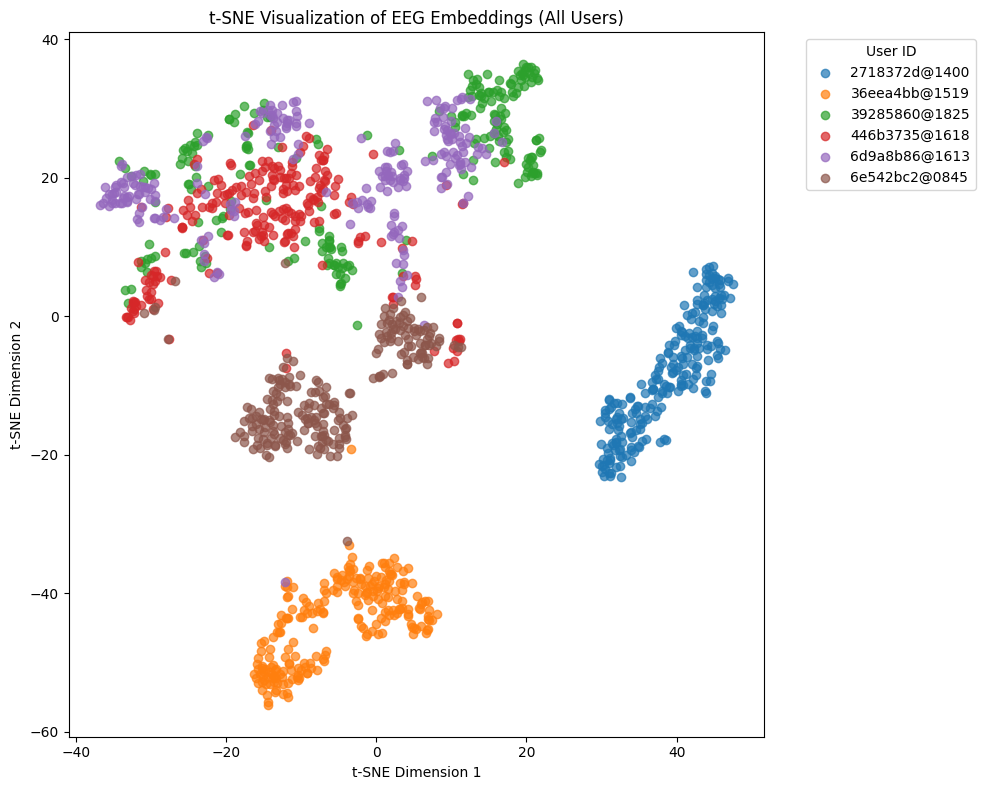

In [19]:
best_threshold, eer, frr, far, tsne_coords = run_threshold_and_visualization(model, test_df)